### Block particle filter

In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, math, pandas, numpy.random as npr, multiprocessing as mp
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from tqdm import trange
from ecology_functions import *

In [2]:
def block_pf(Y, x_0, n_particles, theta) : # I = number of locations, K = dimension at each location
    
    I, J = np.shape(Y)[1:]
    K = np.shape(x_0)[-1]
    particles = np.zeros((T+1,n_particles,I,K))   # I = number of locations, K = dimension at each location
    particles[0] = x_0
    weights = np.ones((n_particles,I))/n_particles 
    
    for t in trange(T) :
        # propagation:
        particles[t+1] = propagate(particles[t], theta)  

        #weighting:
        for i in range(I) :
            weights[:,i] = local_potential(Y[t,i], particles[t+1,:,i], theta, location=i)
            weights[:,i] /= np.sum(weights[:,i])
            
        # resampling:
        for i in range(I) :
            resampled_idx = npr.choice(a=n_particles, size=n_particles, p=weights[:,i])
            particles[t+1,:,i] = particles[t+1,resampled_idx,i]
            
    return particles, weights

In [20]:
T = 100
I = 5  # number of locations
J = 3  # number of species
K = 2  # number of latent factors

In [21]:
lmbda = npr.randn(J,K)
alpha = npr.randn(J)
c = 0
phi = 0.5
logsigmasq = 0
x_0 = npr.randn(I,K)

theta = [alpha, lmbda, c, phi, logsigmasq]
Y, X = simulate_data(x_0, T, J, theta)

In [27]:
n_particles = 10_000
particles, weights = block_pf(Y, x_0, n_particles, theta)

100%|██████████| 100/100 [01:12<00:00,  1.30it/s]


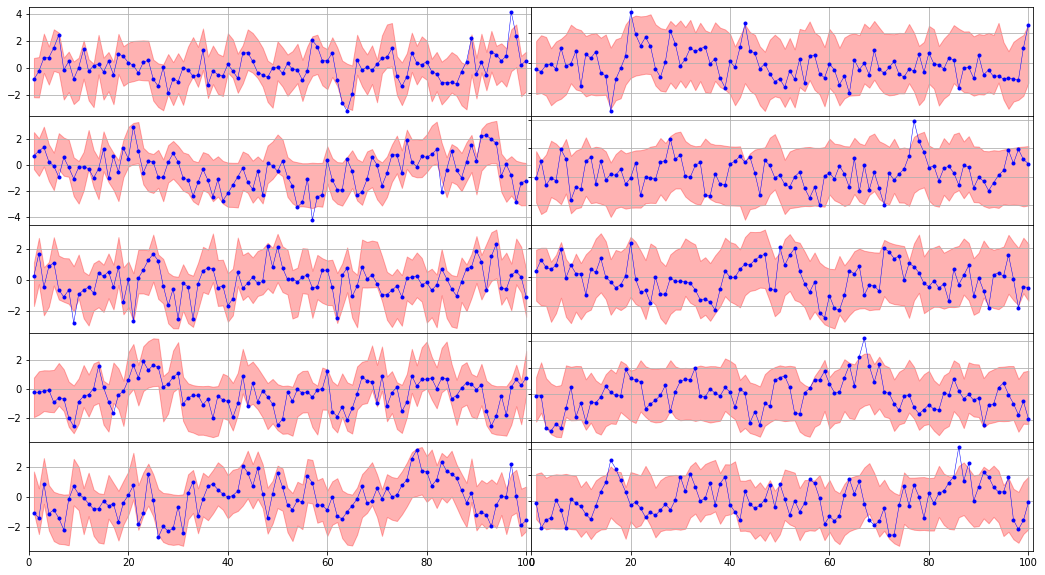

In [37]:
plt.rcParams['figure.figsize'] = (18, 10)
for i in range(I) :
    for k in range(K) :
        idx = i*K + k + 1
        plt.subplot(I,K,idx)
        ci = np.percentile(particles[1:,:,i,k], axis=1, q=[2.5,97.5])
        plt.rcParams['figure.figsize'] = (16, 3.5)
        plt.plot(np.arange(1,T+1), X[1:,i,k], 'bo-', markersize=3, lw=0.5)
        plt.fill_between(np.arange(1,T+1), ci[0], ci[1], color='red', alpha=.3)
        plt.grid(True)
        plt.xlim(0,T+1)
        if i < (I-1) : plt.xticks(alpha=0)
        if k == (K-1) : plt.yticks(alpha=0)
        plt.subplots_adjust(hspace=0,wspace=0)